### Decision trees

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with decision trees.
Slides at http://www.cs.ubc.ca/~nando/540-2013/lectures/l8.pdf

In [153]:
%matplotlib inline
import graphviz as gv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

# path to png's
PATH = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\tut_png\\decision_trees\\'

Decision trees don't generalize well and have very high variance in their predictions but if you take many trees and you average them, you can get rid of the variance. This is in essence what a Random Forest does but let's start with a simple decision tree. 

A general tree structure is basically a structure that splits and categorizes datapoints. 

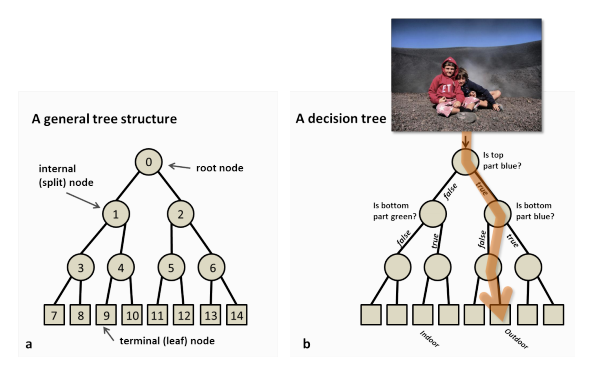

In [155]:
Image(PATH + 'random_decision_tree.png')

Assume that in the root node my data has 5 cases: 3 of the negative class, 2 of the positive class. We apply our first decision right here. F.i. we could have data about the height, weight of individuals and a first decision could be a split off of height > 2m. Only individuals > 2m will go left. Then another decision point comes by: >200kg. This process continues until reaching the terminal leaf node. Not all these leaf nodes will be filled but the ones that are can predict a test point.

You can assoaciate a histogram to each node. So if you are a datapoint and you didn't go through the tree yet, you would have probability $\frac{3}{5}$ that you would have a red label. So we have 5 datapoints:

$x_{1} = (2, 3.6), y_{1} = \circ_{green}$
$x_{2} = (5, 5.6), y_{2} = \circ_{green}$
$x_{3} = (.., ...), y_{3} = \circ_{green}$
$x_{4} = (.., ...), y_{4} = \circ_{green}$
$x_{5} = (.., ...), y_{5} = \circ_{green}$

Trees basically bin the data points into separate groups. In practise you won't have terminal nodes with a 100% probability that a test points has a certain label, but rather multi-histograms and probabilities of a class given a test datapoint.

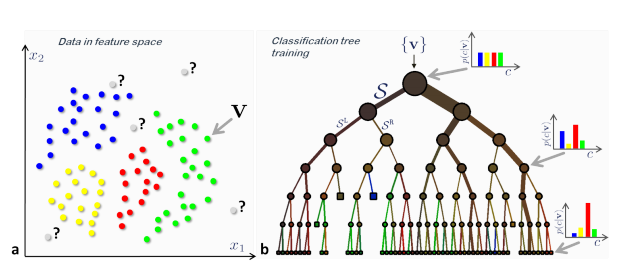

In [162]:
Image(PATH + 'random_decision_tree2.png')

In [163]:
iris = datasets.load_iris()

features = iris.data
targets = iris.target
col_names = iris.feature_names
col_names.insert(4, 'name')

In [164]:
df = pd.DataFrame(np.column_stack((features, targets)), columns=col_names)

In [165]:
features = list(df.columns[:4]); targets = list(df.columns[-1:])

y = df[targets]
X = df[features]

dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [166]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [167]:
visualize_tree(dt, features)`b


After running this, the script makes a file in the current directory called "lens_dtree.dot". The dot format is kind of strange but it's how this kind of thing exports; we use graphviz and the command line to change this dot file into another file that's easier for us to look at. In a terminal or command line, go to the folder that contains this dot file and run

In [178]:
def entropy(pmf):
    return -(pmf * np.log(pmf)/np.log(2)).sum()

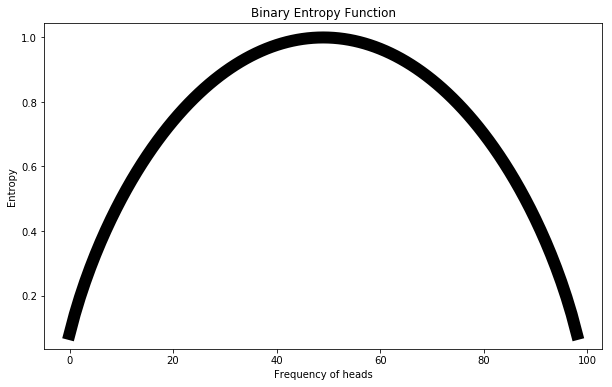

In [187]:
fig, ax = plt.subplots(figsize=[10,6])

x = np.arange(0.01,1,.01)
pmfs = np.vstack((x,1-x)).T
 
Entropy = []
 
for i in range(pmfs.shape[0]):
    Entropy.append(entropy(pmfs[i,:]))
 
# plot
ax.plot(binaryEntropy,'black',linewidth=12)
ax.set(title = 'Binary Entropy Function', xlabel = 'Frequency of heads', 
       ylabel = 'Entropy');

Imagine the well known example recommended by the **AI book by Stuart Russell & Peter Norvig**. (This book has been translated to code and is available at github: https://github.com/aimacode/aima-python/tree/63458a9da514ec89877c10d090141e3d0f89bbcb

Consider the feature table below and the target to see if a customer is willing to wait  for his table or will go own searching for a next restaurant. 

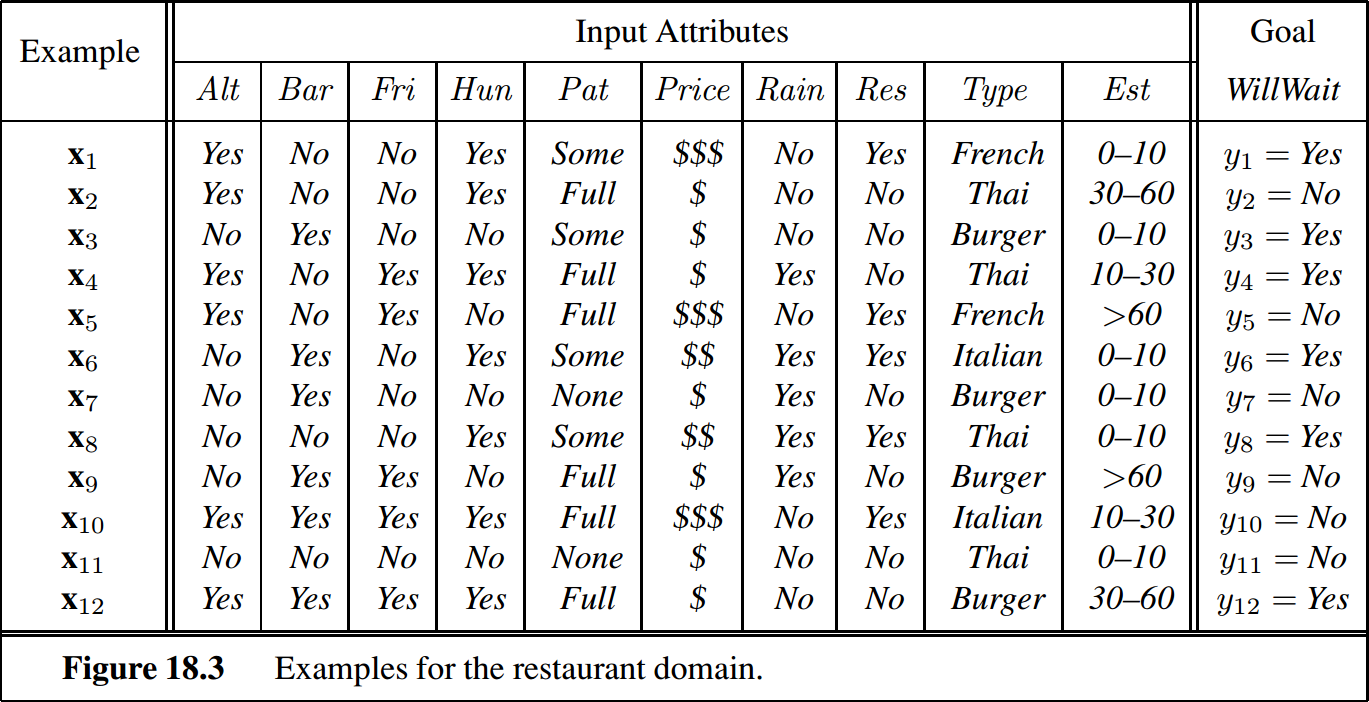

In [171]:
Image(PATH + 'restaurant_trees_example_peter_norvig.png')

We build trees in a greedy fashion to avoid combinatorial explosions so we should decide what the first node should be. An idea: a good attribute splits the examples into subsets that are ideally 'all postive' or all 'negative'. Comparing the 2 features TYPE vs PAT will give that PAT gives more information about the classification and splits better. In order to make those decision we use the concept of **entropy which is a measure of uncertainty**. For a binary variable this would be:

$H(\frac{P}{P+N} \frac{N}{P+N}) = \underset{class_1}{- \frac{N}{P+N} \log_{2} \frac{N}{P+N}} - \underset{class_2}{\frac{N}{P+N} \log_{2} \frac{N}{P+N}}$

or more generally:

$H(x) = - \sum^{n}_{i =1} p(x_{i})  \log_{2} p(x_{i})$ 

This reads as the probability of positive class label times log of the probability of positive - probability of negative x log probability of negative. This entropy is for 2 classes but the log formula gets very long with multiple classes.

A chosen attribute A (one of the columns in the table) with K distinct values, divides the training set $\mathbf{E}$ into subsets $E_{1}, E_{2}, .. E_{k}$. The **Expected Entropy (EH)** remaining after trying attribute A (with branches $i = 1,2, ...k$ is:

$EH(A) = \sum^{k}_{i =1} \frac{P_{i}+ N_{i}}{P+N} H( \frac{P_{i}}{P_{i}+N_{i}}, \frac{N_{i}}{P_{i}+N_{i}})$

Thing is that you don't know beforehand that a point will end up in any of the children nodes. So you need to compute the expectation. When you split the data, there will be a certain entropy left in your children nodes. While you cannot predict how many points will end up in each leaf, you certainly can compute the probability. 

In [196]:
# Calculates the entropy of the given data set for the target attribute.
def entropy(data, target_attr):
 
    val_freq = {}
    data_entropy = 0.0
 
    # Calculate the frequency of each of the values in the target attr
    for record in data:
        if (val_freq.has_key(record[target_attr])):
            val_freq[record[target_attr]] += 1.0
        else:
            val_freq[record[target_attr]]  = 1.0
 
    # Calculate the entropy of the data for the target attribute
    for freq in val_freq.values():
        data_entropy += (-freq/len(data)) * math.log(freq/len(data), 2) 
 
    return data_entropy

In addition we define a quantity called **Information Gain (IG)** or rediction in entropy. It's the measure of the difference in entropy from before to after the data set S is split on an attribute A. In other words, how much uncertainty in S was reduced after splitting data set S on attribute A. It's a synonym for **Kullback–Leibler divergence** (in the context of decision trees, the term is sometimes used synonymously with mutual information, which is the expectation value of the Kullback–Leibler divergence of a conditional probability distribution.

$IG(A) = H(\frac{P}{P+N}, \frac{N}{P+N}) - EH(A)$

Let's plug in the numbers for the PAT and TYPE attributes of the resaurant table: 

$IG(pat) = 1 - [\frac{2}{12}H(0,1)+\frac{4}{12}H(1, 0) +\frac{6}{12}H(\frac{2}{6}\frac{4}{6})] = 0.541 bits$

$IG(type) = 1 - [\frac{2}{12}H(\frac{1}{2}\frac{1}{2})+\frac{2}{12}H(\frac{1}{2}\frac{1}{2}) +\frac{4}{12}H(\frac{2}{4}\frac{2}{4}) + \frac{4}{12}H(\frac{2}{4}, \frac{2}{4})] = 0 bits$

Where 1 - is the entropy of the parent node. Here we would obvisouly choose the PAT attribute.

In [198]:
# Calculates the information gain (reduction in entropy) that would result by splitting the data on the chosen attribute (attr).
def information_gain(data, attr, target_attr):
 
    val_freq = {}
    subset_entropy = 0.0
 
    # Calculate the frequency of each of the values in the target attribute
    for record in data:
        if (val_freq.has_key(record[attr])):
            val_freq[record[attr]] += 1.0
        else:
            val_freq[record[attr]]  = 1.0
 
    # Calculate the sum of the entropy for each subset of records weighted by their probability of occuring in the training set.
    for val in val_freq.keys():
        val_prob = val_freq[val] / sum(val_freq.values())
        data_subset = [record for record in data if record[attr] == val]
        subset_entropy += val_prob * entropy(data_subset, target_attr)
 
    # Subtract the entropy of the chosen attribute from the entropy of the whole data set with respect to the target attribute (and return it)
    return (entropy(data, target_attr) - subset_entropy)